In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Для кириллицы на графиках
font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

# Майнор по Анализу Данных, Группа ИАД-2
## 10/04/2017  Отбор признаков и понижение размерности

# Проклятье размености

<center><img src='http://www.visiondummy.com/wp-content/uploads/2014/04/curseofdimensionality.png'></center>

## Способы понижения размерности

Избавляться от размерности можно методами **отбора признаков (Feature Selection)** и методами **уменьшения размерности (Feature Reduction)**

### Feature Selection
Методы деляться на три группы:
* Filter methods 
    * Признаки рассматриваются независимо друг от друга
    * Изучается индивидуальный "вклад" призника в предсказываемую переменную
    * Быстрое вычисление
* Wrapper methods
    * Идет отбор группы признаков
    * Может быть оооочень медленным, но качество, обычно, лучше чем у Filter Methods
* Embedded methods
    * Отбор признаков "зашит" в модель
    * *Пример?*

### Filter method - Mutual Information
$$MI(y,x) = \sum_{x,y} p(x|y) \ln\left[\frac{p(x|y)}{p(x)p(y)}\right]$$
Сколько информации $x$ сообщает об $y$.
$$NormalizedMI(y,x) = \frac{MI(y,x)}{H(y)}$$

Загрузим довольно известный набор данных о выживаемости после катастрофы титаника.

In [2]:
df_titanic = pd.read_csv('data/titanic.csv')
df_titanic.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [3]:
pd.crosstab(df_titanic.Survived, df_titanic.Sex)

Sex       female  male
Survived              
0             81   468
1            233   109

Найдем MI между выживаемостью и остальными признаками

In [4]:
# def calc_mutual_information(y, x):
#     P = pd.crosstab(y, x, normalize=True)
#     P1 = P/P.sum(axis=0)
#     P1 = (P1.T)/P.sum(axis=1)
#     logP = np.log(P1.T)
#     return (P*logP).sum().sum()

def calc_mutual_information(y, x):
    P = pd.crosstab(x, y, normalize=True).values
    logP = np.log(((P/P.sum(axis=0)).T/P.sum(axis=1)).T)
    return (P*logP).sum()

In [5]:
calc_mutual_information(df_titanic.loc[:, 'Survived'], df_titanic.loc[:, 'Sex'])

0.15087048925218172

In [6]:
from sklearn.metrics import mutual_info_score
from sklearn.metrics import normalized_mutual_info_score

In [7]:
mutual_info_score(df_titanic.Survived, df_titanic.Sex)

0.15087048925218183

### Wrapper Methods - Recursive Feature Elimination

При данном подходе из (линейной) модели последовательно удаляются признаки с наименьшим коэффициентом


Используйте реализацию RFE в sklean c кросс-валидацией.

* Обучите модель
* Выведите на графике размер признакового пространства и полученное качество
* Выведите веса признаков в выбранном признаковом пространстве

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

In [9]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

In [10]:
def titanic_preproc(df_input):
    df = df_input.copy()
    
    # Удаляем пропуски
    df = df.dropna()

    # Создаем такой признак
    df.loc[:, 'has_cabin'] = df.loc[:, 'Cabin'].isnull().astype(int) 
    
    # Удаляем колонки
    cols2drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']
    df = df.drop(cols2drop, axis=1)
    
    # Нормализуем Age Fare и SibSp (Так делать не оч хорошо)
    df.loc[:, 'Age'] = (df.loc[:, 'Age'] - df.loc[:, 'Age'].mean())/df.loc[:, 'Age'].std()
    df.loc[:, 'Fare'] = (df.loc[:, 'Fare'] - df.loc[:, 'Fare'].mean())/df.loc[:, 'Fare'].std()
    df.loc[:, 'SibSp'] = (df.loc[:, 'SibSp'] - df.loc[:, 'SibSp'].mean())/df.loc[:, 'SibSp'].std()
    
    # Закодируем поле Sex
    df.loc[:, 'Sex'] = df.loc[:, 'Sex'].replace({'male': 0, 'female':1})
    
    # Pclass и Embarked можно рассматривать как категориальный признак
    df = pd.get_dummies(df, prefix_sep='=', columns=['Pclass', 'Embarked'], drop_first=True)
        
    return df

In [11]:
df_prep = df_titanic.pipe(titanic_preproc)
X, y = df_prep.iloc[:, 1:].values, df_prep.iloc[:, 0].values

In [12]:
model = LogisticRegression(random_state=123)
rfe = RFECV(model, step=1, cv=cv, scoring='roc_auc', verbose=1, n_jobs=-1)

In [13]:
rfe.fit(X, y)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
   estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=123, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
   n_jobs=-1, scoring='roc_auc', step=1, verbose=1)

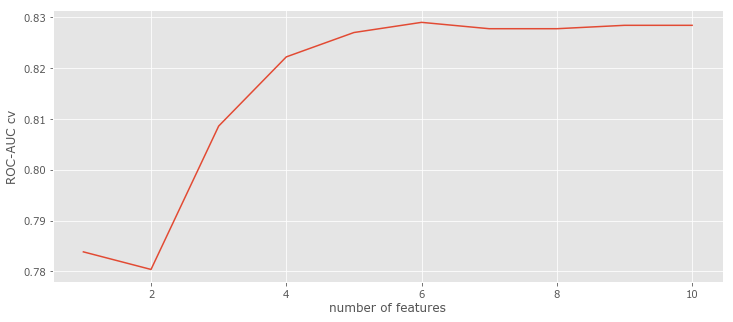

In [14]:
d = rfe.grid_scores_.shape[0]
plt.plot(range(1,d+1), rfe.grid_scores_)
plt.xlabel('number of features')
plt.ylabel('ROC-AUC cv');

In [15]:
print("Выбранные признаки")
fnames = df_prep.columns[1:].values
print(fnames[rfe.support_])
pd.Series(index=fnames[rfe.support_], data=rfe.estimator_.coef_[0])

# print(df_prep.columns[1:][rfe.support_])
# print(rfe.estimator_.coef_)

Выбранные признаки
['Sex' 'Age' 'Parch' 'Pclass=3' 'Embarked=Q' 'Embarked=S']


Sex           2.372815
Age          -0.554682
Parch        -0.243279
Pclass=3     -0.931482
Embarked=Q   -0.329946
Embarked=S   -0.338861
dtype: float64

### Embedded methods

* Обучите случайный лес на данных
* Выведите важность признаков и сравните с выдачей по Filter и Wrapper подходам

In [16]:
## Your code here 

# Principal Component Analysis
## Метод Главных Компонент

# PCA

* Позволяет уменьшить число переменных, выбрав самые изменчивые из них
* Новые переменные являются линейной комбинацией старых переменных
* Переход к ортономированному базису

<center><img src='http://www.visiondummy.com/wp-content/uploads/2014/05/correlated_2d.png' width=600></center>

### FYI (Посмотрите дома, если интересно)

### Построение PCA
*  Пусть $x \in \mathbb{R}^d$ - вектор признаков для какого-то объекта. Будем считать, что $x$ - центрировано и отшкалировано. $ (mean) E[x_i] = 0, (std) V[x_i] = 1, \quad i=1 \dots d$
* Требуется найти линейное преобразование, которое задается ортогональной матрицей $A$:
$$ pc = A^\top x $$

* $pc_i = a_i^\top x = x^\top a_i$  (pc = principle_components)
* $cov[x] = E[(x - E[x])(x - E[x])^\top] = Exx^\top = \Sigma$ -  ковариационная матрица

* $E[pc_i] = E[a_i^\top x] = a_i^\top E[x]$
* $cov[pc_i, pc_j] = E[pc_i \cdot pc_j^\top] = a_i^\top \Sigma a_j $
* $\Sigma$ - симметричная и положительно определенная матрица.
    * Собственные числа $\lambda_i \in \mathbb{R}, \lambda_i \geq 0$ (Будем считать, что $\lambda_1 > \lambda_2  > \dots > \lambda_d $
    * Собственные вектора при $\lambda_i \neq \lambda_j $ ортогональны: $v_i^\top v_j = 0$
    * У каждого $\lambda_i$ есть единственный $v_i$

### Первая компонента
$$ pc_1 = a_1 ^\top x $$

\begin{equation}
\begin{cases}
V[pc_1] = a_1^\top \Sigma a_1 \rightarrow \max_a \\
a_1^\top a_1 = 1
\end{cases}
\end{equation}
* Строим функцию лагранжа
$$ \mathcal{L}(a_1, \nu) = a_1^\top \Sigma a_1 - \nu (a_1^\top a_1 - 1) \rightarrow max_{a_1, \nu}$$
* Считаем производую по $a_1$
$$ \frac{\partial\mathcal{L}}{\partial a_1} = 2\Sigma a_1 - 2\nu a_1 = 0 $$
* Получается, что $a_1$ один из собственных векторов матрицы $\Sigma$, причем при $\lambda_1$
$$ V[pc_1] = a_1^\top \Sigma a_1 = \lambda_i a_1^\top a_1 = \lambda_i $$

### Вторая компонента
$$ pc_2 = a_2 ^\top x $$

\begin{equation}
\begin{cases}
V[pc_1] = a_2^\top \Sigma a_2 \rightarrow \max_a \\
a_2^\top a_2 = 1 \\
cov[pc_1, pc_2] = a_2^\top \Sigma a_1 = \lambda_1 a_2^\top a_1 = 0
\end{cases}
\end{equation}
* Строим функцию лагранжа
$$ \mathcal{L}(a_2, \nu, \tau) = a_2^\top \Sigma a_2 - \nu (a_2^\top a_2 - 1) - \tau a_2^\top a_1 \rightarrow max_{a_1, \nu}$$

Аналогичными выкладками приходим к тому, что $a_2$ - собственный вектор $\Sigma$ при $\lambda_2$

## Singular Value Decomposition

Для любой матрицы $X$ размера $n \times m$ можно найти разложение вида:
$$ X = U S V^\top ,$$
где 
* $U$ - унитарная матрица, состоящая из собственных векторов $XX^\top$
* $V$ - унитарная матрица, состоящая из собственных векторов $X^\top X$
* $S$ - диагональная матрица с сингулярными числами $s_i = \sqrt{\lambda_i}$

Матрицы $U$ и $V$ ортогональны и могут быть использованы для перехода к ортогональному базису:
$$ XV = US$$

Сокращение размерности заключается в том, что вместо того, чтобы умножать $X$ на всю матрицу $V$, а лишь на первые $k<m$ её столбцов - матрицу $V'$

Квадраты сингулярных чисел в $S$ содержат дисперсию, объясненную в главных компонентах

## MNIST
<center><img src='https://habrastorage.org/files/cca/f67/7de/ccaf677ded5d4028a3095e9bfbd7fa19.png'></center>

## MNIST PCA

<center><img src='http://nikhilbuduma.com/img/autoencoder_digit_exp.png' width=800></center>

## Игрушечный пример

In [17]:
from sklearn.decomposition import PCA
from numpy.linalg import svd
from sklearn.datasets import load_digits

In [18]:
C = np.array([[0., -0.7], [1.5, 0.7]])
X = np.dot(np.random.randn(200, 2) + np.array([4, 2]), C)
X = (X - X.mean(axis=0))/X.std(axis=0)

(-3.0028086091123414,
 3.3141560435829618,
 -3.783087209818162,
 2.9815063516207836)

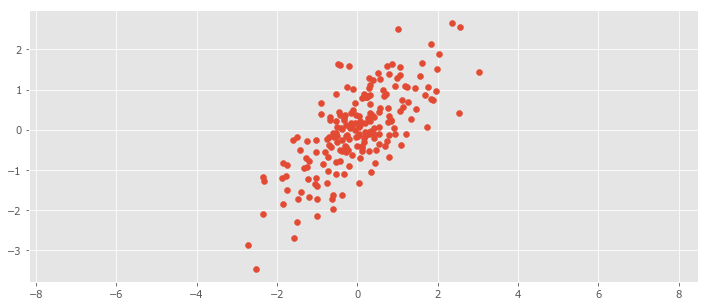

In [19]:
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal')

In [20]:
pca = PCA(n_components=2)

In [21]:
PC = pca.fit_transform(X)

In [22]:
PC[:10]  # new features

array([[-0.24578915,  0.28555253],
       [-0.07851077,  0.15846354],
       [-3.5561583 ,  0.20987446],
       [-1.14673348,  0.2506818 ],
       [ 2.68338765, -0.56902383],
       [ 2.49358696,  0.81834771],
       [ 0.48779502,  0.36510927],
       [-0.14080237, -0.44702535],
       [ 0.04263902,  0.02479239],
       [-1.13657952, -0.76560716]])

In [23]:
coef = pca.components_  # linear components of old features
coef

array([[-0.70710678, -0.70710678],
       [-0.70710678,  0.70710678]])

(-4.0201334068632244,
 4.6427312149745452,
 -1.6456930175706967,
 1.6597043478941291)

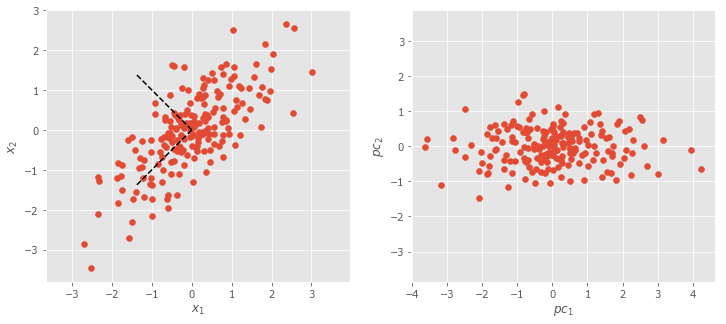

In [24]:
m = np.mean(X,axis=0)

fig, ax = plt.subplots(1,2)

ax[0].plot([0, coef[0,0]*2]+m[0], [0, coef[0,1]*2]+m[1],'--k')
ax[0].plot([0, coef[1,0]*2]+m[0], [0, coef[1,1]*2]+m[1],'--k')
ax[0].scatter(X[:,0], X[:,1])
ax[0].set_xlabel('$x_1$')
ax[0].set_ylabel('$x_2$')

ax[1].scatter(PC[:,0], PC[:,1])
ax[1].set_xlabel('$pc_1$')
ax[1].set_ylabel('$pc_2$')

ax[0].axis('equal')
ax[1].axis('equal')

#### Сделаем все тоже самое через  SVD

In [25]:
X = (X - X.mean(axis=0))/X.std(axis=0)
U, S, V_T = svd(X)

In [26]:
print(U.shape, S.shape, V_T.shape)

(200, 200) (2,) (2, 2)


In [27]:
pca.components_

array([[-0.70710678, -0.70710678],
       [-0.70710678,  0.70710678]])

In [28]:
V_T

array([[ 0.70710678,  0.70710678],
       [ 0.70710678, -0.70710678]])

In [29]:
PC[:10]

array([[-0.24578915,  0.28555253],
       [-0.07851077,  0.15846354],
       [-3.5561583 ,  0.20987446],
       [-1.14673348,  0.2506818 ],
       [ 2.68338765, -0.56902383],
       [ 2.49358696,  0.81834771],
       [ 0.48779502,  0.36510927],
       [-0.14080237, -0.44702535],
       [ 0.04263902,  0.02479239],
       [-1.13657952, -0.76560716]])

In [30]:
V = V_T.T
PC2 = X.dot(V)
PC2[:10]

array([[ 0.24578915, -0.28555253],
       [ 0.07851077, -0.15846354],
       [ 3.5561583 , -0.20987446],
       [ 1.14673348, -0.2506818 ],
       [-2.68338765,  0.56902383],
       [-2.49358696, -0.81834771],
       [-0.48779502, -0.36510927],
       [ 0.14080237,  0.44702535],
       [-0.04263902, -0.02479239],
       [ 1.13657952,  0.76560716]])

In [31]:
PC2 = X.dot(V[:, [0]])
PC2[:10]

array([[ 0.24578915],
       [ 0.07851077],
       [ 3.5561583 ],
       [ 1.14673348],
       [-2.68338765],
       [-2.49358696],
       [-0.48779502],
       [ 0.14080237],
       [-0.04263902],
       [ 1.13657952]])

In [32]:
pca.explained_variance_ratio_

array([ 0.86198212,  0.13801788])

In [33]:
S**2/(S**2).sum()

array([ 0.86198212,  0.13801788])

## Чиселки

In [34]:
digits = load_digits()
X = digits.images
y = digits.target

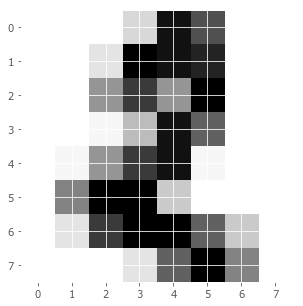

In [35]:
plt.imshow(X[2,:], cmap='Greys', interpolation='none')

#### Задание
* Переведите изображения к формату "матрица объект-признак" (reshape)
* Выполните PCA c двумя компонентами и изобратите полученные точки на плоскости, раскаживая каждую точку в отдельный цвет в соответствии с `y`
* Отнормируйте данные, запустите SVD, домножте `X` на нужную матрицу и убедитесь, что у вас получается тот же результат

In [36]:
X_new = X.reshape(X.shape[0], -1)
X_new.shape

(1797, 64)

In [37]:
pca = PCA(n_components=2)
pc = pca.fit_transform(X_new)
print(pc.shape, pca.explained_variance_ratio_)
pc[:10]

(1797, 2) [ 0.14890594  0.13618771]


array([[ -1.25946704,  21.27488532],
       [  7.95761342, -20.76869385],
       [  6.99192206,  -9.95599085],
       [-15.90610479,   3.33246635],
       [ 23.30686758,   4.26906178],
       [-14.08708801,   7.91444723],
       [ 21.36341012,   5.28834159],
       [ -2.95260954, -21.07167231],
       [ -5.25513497,   1.18336034],
       [ -5.48020115,   8.07632606]])

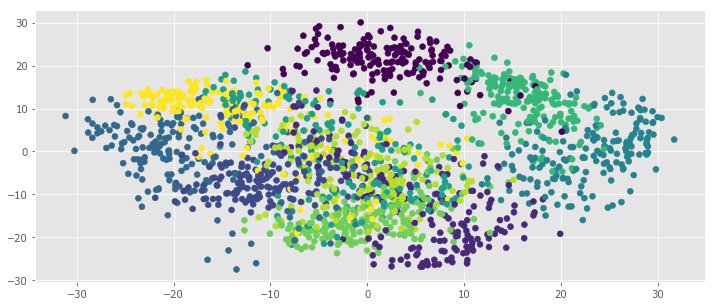

In [38]:
plt.scatter(pc[:, 0], pc[:, 1], c=y);

In [39]:
X_norm = (X_new - X_new.mean(axis=0))/X_new.std(axis=0)
X_norm[np.isnan(X_norm)] = 0
X_norm

C:\Users\d_pch\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([[ 0.        , -0.33501649, -0.04308102, ..., -1.14664746,
        -0.5056698 , -0.19600752],
       [ 0.        , -0.33501649, -1.09493684, ...,  0.54856067,
        -0.5056698 , -0.19600752],
       [ 0.        , -0.33501649, -1.09493684, ...,  1.56568555,
         1.6951369 , -0.19600752],
       ..., 
       [ 0.        , -0.33501649, -0.88456568, ..., -0.12952258,
        -0.5056698 , -0.19600752],
       [ 0.        , -0.33501649, -0.67419451, ...,  0.8876023 ,
        -0.5056698 , -0.19600752],
       [ 0.        , -0.33501649,  1.00877481, ...,  0.8876023 ,
        -0.26113572, -0.19600752]])

In [40]:
Un, Sn, V_Tn = svd(X_norm)
print(Un.shape, Sn.shape, V_Tn.shape)

(1797, 1797) (64,) (64, 64)


In [41]:
Vn = V_Tn.T
pc2 = X_norm.dot(Vn)

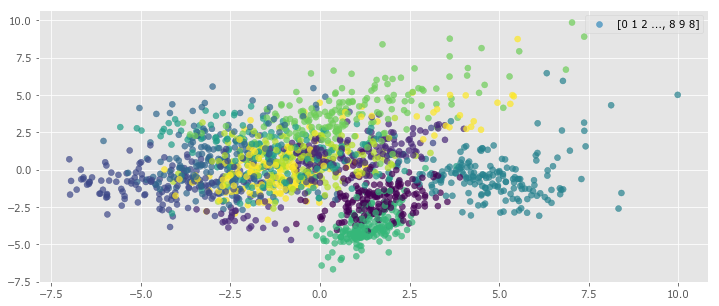

In [42]:
plt.scatter(pc2[:, 0], pc2[:, 1], c=y, label=y, alpha=0.7)
# plt.axis('equal')
plt.legend();

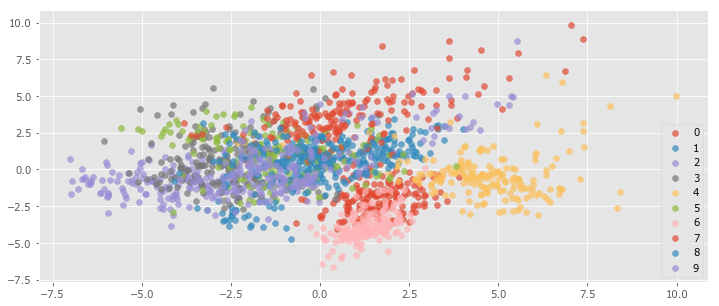

In [43]:
for i in range(10):
    idx = y == i
    plt.scatter(pc2[idx, 0], pc2[idx, 1], label=i, alpha=0.7)
plt.legend();

## Пищевая ценность продуктов

* Загрузите набор данных о пищевом рационе в разных странах мира `diet.csv`
* Примените на данных PCA с 2 компонентами
* Изобразите объекты в сжатом пространстве

In [44]:
df = pd.read_csv(r'data/diet.csv', sep=';')
df.head()

Countries  Energy (kcal/day)  Protein (g/day)  Fats (g/day)  \
0     Albania             2860.0               96            86   
1   Argentina             2980.0               94           100   
2   Australia             3120.0              107           134   
3     Austria             3740.0              111           162   
4  Bangladesh             2200.0               48            25   

   Carbohydrates (g/day)  Animal Products + (kcal/day)  \
0                 425.50                         813.0   
1                 426.00                         823.0   
2                 371.50                        1033.0   
3                 459.50                        1219.0   
4                 445.75                          65.0   

   Animal Fats (kcal/day)  Bovine Meat (kcal/day)  Butter, Ghee (kcal/day)  \
0                      49                      62                       11   
1                      72                     342                       28   
2                     124                     142                       62   
3                     320                      59                      102   
4                       5                       5                        3   

   Cheese (kcal/day)     ...       Starchy Roots (kcal/day)  \
0                 50     ...                             57   
1                 90     ...                            100   
2                107     ...                             87   
3                193     ...                            113   
4                  0     ...                             42   

   Sugar & Sweeteners (kcal/day)  Sugar (Raw Equivalent) (kcal/day)  \
0                            193                                187   
1                            406                                337   
2                            423                                407   
3                            437                                404   
4                             59                                 29   

   Sugar, Raw Equivalent (kcal/day)  Sugar, Refined Equiv (kcal/day)  \
0                               191                              187   
1                               405                              337   
2                               415                              407   
3                               424                              404   
4                                59                               29   

   Vegetable Oils (kcal/day)  Vegetables (kcal/day)  Wheat (kcal/day)  \
0                        174                     94              1166   
1                        311                     51               914   
2                        435                     67               559   
3                        442                     61               617   
4                        131                     10               180   

   Wine (kcal/day)  Unnamed: 50  
0                6          NaN  
1               59          NaN  
2               39          NaN  
3               55          NaN  
4                0          NaN  

[5 rows x 51 columns]

In [45]:
df = df.dropna(axis=1)
df = df.drop('Energy (kcal/day)', axis=1)
df = df.set_index('Countries')

In [46]:
df.head()

Protein (g/day)  Fats (g/day)  Carbohydrates (g/day)  \
Countries                                                          
Albania                  96            86                 425.50   
Argentina                94           100                 426.00   
Australia               107           134                 371.50   
Austria                 111           162                 459.50   
Bangladesh               48            25                 445.75   

            Animal Products + (kcal/day)  Animal Fats (kcal/day)  \
Countries                                                          
Albania                            813.0                      49   
Argentina                          823.0                      72   
Australia                         1033.0                     124   
Austria                           1219.0                     320   
Bangladesh                          65.0                       5   

            Bovine Meat (kcal/day)  Butter, Ghee (kcal/day)  \
Countries                                                     
Albania                         62                       11   
Argentina                      342                       28   
Australia                      142                       62   
Austria                         59                      102   
Bangladesh                       5                        3   

            Cheese (kcal/day)  Eggs (kcal/day)  Fats, Animals, Raw (kcal/day)  \
Countries                                                                       
Albania                    50               22                             38   
Argentina                  90               24                             42   
Australia                 107               23                             61   
Austria                   193               49                            200   
Bangladesh                  0                3                              2   

                 ...         Soyabean Oil (kcal/day)  \
Countries        ...                                   
Albania          ...                               2   
Argentina        ...                              43   
Australia        ...                              17   
Austria          ...                              89   
Bangladesh       ...                              48   

            Starchy Roots (kcal/day)  Sugar & Sweeteners (kcal/day)  \
Countries                                                             
Albania                           57                            193   
Argentina                        100                            406   
Australia                         87                            423   
Austria                          113                            437   
Bangladesh                        42                             59   

            Sugar (Raw Equivalent) (kcal/day)  \
Countries                                       
Albania                                   187   
Argentina                                 337   
Australia                                 407   
Austria                                   404   
Bangladesh                                 29   

            Sugar, Raw Equivalent (kcal/day)  Sugar, Refined Equiv (kcal/day)  \
Countries                                                                       
Albania                                  191                              187   
Argentina                                405                              337   
Australia                                415                              407   
Austria                                  424                              404   
Bangladesh                                59                               29   

            Vegetable Oils (kcal/day)  Vegetables (kcal/day)  \
Countries                                                      
Albania                           174                     94   
Argentina                         311                

In [47]:
X = df.values
X = (X - X.mean(axis=0))/X.std(axis=0)  # norm

In [48]:
pca = PCA(n_components=2)
pc = pca.fit_transform(X)

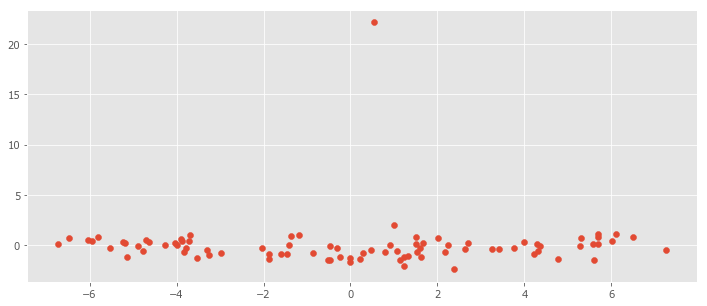

In [49]:
plt.scatter(pc[:, 0], pc[:, 1]);

In [50]:
idx = np.where(pc[:, 1] > 15)[0]
df.iloc[idx]

Protein (g/day)  Fats (g/day)  Carbohydrates (g/day)  \
Countries                                                         
Iran                  3090            83                   61.0   

           Animal Products + (kcal/day)  Animal Fats (kcal/day)  \
Countries                                                         
Iran                             552.25                     297   

           Bovine Meat (kcal/day)  Butter, Ghee (kcal/day)  Cheese (kcal/day)  \
Countries                                                                       
Iran                           49                       29                 49   

           Eggs (kcal/day)  Fats, Animals, Raw (kcal/day)       ...         \
Countries                                                       ...          
Iran                    12                             27       ...          

           Soyabean Oil (kcal/day)  Starchy Roots (kcal/day)  \
Countries                                                      
Iran                            94                       145   

           Sugar & Sweeteners (kcal/day)  Sugar (Raw Equivalent) (kcal/day)  \
Countries                                                                     
Iran                                  94                                258   

           Sugar, Raw Equivalent (kcal/day)  Sugar, Refined Equiv (kcal/day)  \
Countries                                                                      
Iran                                    254                              254   

           Vegetable Oils (kcal/day)  Vegetables (kcal/day)  Wheat (kcal/day)  \
Countries                                                                       
Iran                             254                    200                98   

           Wine (kcal/day)  
Countries                   
Iran                  1468  

[1 rows x 48 columns]

In [51]:
df.iloc[idx, :].T

Countries                               Iran
Protein (g/day)                      3090.00
Fats (g/day)                           83.00
Carbohydrates (g/day)                  61.00
Animal Products + (kcal/day)          552.25
Animal Fats (kcal/day)                297.00
Bovine Meat (kcal/day)                 49.00
Butter, Ghee (kcal/day)                29.00
Cheese (kcal/day)                      49.00
Eggs (kcal/day)                        12.00
Fats, Animals, Raw (kcal/day)          27.00
Fish, Seafood (kcal/day)                0.00
Freshwater Fish (kcal/day)             11.00
Honey (kcal/day)                        3.00
Meat (kcal/day)                         3.00
Milk - Excluding Butter (kcal/day)    114.00
Milk, Whole (kcal/day)                 87.00
Mutton & Goat Meat (kcal/day)          59.00
Offals, Edible (kcal/day)              42.00
Pelagic Fish (kcal/day)                 7.00
Pigmeat (kcal/day)                      6.00
Poultry Meat (kcal/day)                 0.00
Vegetal Products + (kcal/day)          41.00
Alcoholic Beverages (kcal/day)       2807.00
Apples (kcal/day)                       0.00
Bananas (kcal/day)                     39.00
Beans (kcal/day)                        6.00
Cereals - Excluding Beer (kcal/day)    20.00
Coconut Oil (kcal/day)               1832.00
Coffee (kcal/day)                       0.00
Fruits - Excluding Wine (kcal/day)      0.00
Nuts (kcal/day)                       225.00
Olive Oil (kcal/day)                   40.00
Palm Oil (kcal/day)                     0.00
Potatoes (kcal/day)                     0.00
Pulses (kcal/day)                      94.00
Rice (Milled Equivalent) (kcal/day)    45.00
Rice (Paddy Equivalent) (kcal/day)    341.00
Roots & Tuber Dry Equiv (kcal/day)    341.00
Soyabean Oil (kcal/day)                94.00
Starchy Roots (kcal/day)              145.00
Sugar & Sweeteners (kcal/day)          94.00
Sugar (Raw Equivalent) (kcal/day)     258.00
Sugar, Raw Equivalent (kcal/day)      254.00
Sugar, Refined Equiv (kcal/day)       254.00
Vegetable Oils (kcal/day)             254.00
Vegetables (kcal/day)                 200.00
Wheat (kcal/day)                       98.00
Wine (kcal/day)                      1468.00

In [52]:
pd.DataFrame(df.values - df.iloc[idx].values, columns=df.columns).mean()

Protein (g/day)                       -2973.465116
Fats (g/day)                              7.174419
Carbohydrates (g/day)                   372.802326
Animal Products + (kcal/day)             48.218023
Animal Fats (kcal/day)                 -199.267442
Bovine Meat (kcal/day)                    6.325581
Butter, Ghee (kcal/day)                   3.500000
Cheese (kcal/day)                         2.790698
Eggs (kcal/day)                          15.883721
Fats, Animals, Raw (kcal/day)            25.569767
Fish, Seafood (kcal/day)                 33.023256
Freshwater Fish (kcal/day)               -6.883721
Honey (kcal/day)                         -0.337209
Meat (kcal/day)                         237.127907
Milk - Excluding Butter (kcal/day)       73.988372
Milk, Whole (kcal/day)                   30.616279
Mutton & Goat Meat (kcal/day)           -35.965116
Offals, Edible (kcal/day)               -31.906977
Pelagic Fish (kcal/day)                   7.802326
Pigmeat (kcal/day)             

In [53]:
X = df.drop(['Iran'], axis=0).values
X = (X - X.mean(axis=0))/X.std(axis=0)

In [54]:
pca = PCA(n_components=2)
pc = pca.fit_transform(X)

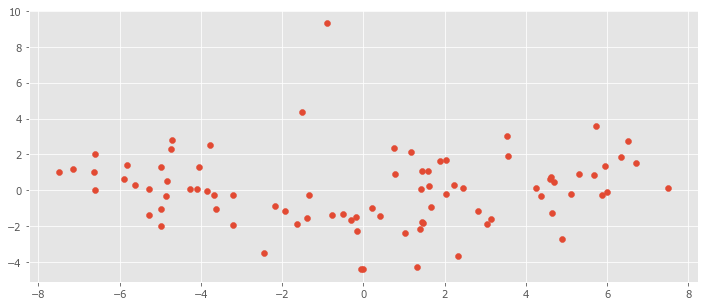

In [55]:
plt.scatter(pc[:, 0], pc[:, 1]); # есть еще выбросы

In [56]:
# попытка проинтепретировать
print(pca.components_.shape)
pca.components_

(2, 48)


array([[-0.22342645, -0.23286786, -0.05394842, -0.23754846, -0.19464646,
        -0.10705411, -0.16141475, -0.20617676, -0.18188237, -0.16634558,
        -0.06430373,  0.02221167, -0.13833901, -0.20930272, -0.20295366,
        -0.11417801, -0.04162779, -0.0761091 , -0.03157869, -0.18432062,
        -0.14001236, -0.08772739, -0.18972534, -0.19101052, -0.00546431,
         0.053688  ,  0.10742972, -0.02047277, -0.16674704, -0.08002716,
        -0.15704544, -0.08869607,  0.08652202, -0.14556442,  0.10486317,
         0.14032585,  0.14032585,  0.06619042, -0.05705582,  0.06619042,
        -0.18428374, -0.1784082 , -0.18240906, -0.1784082 , -0.13621429,
        -0.14817102, -0.13029124, -0.18086387],
       [-0.07240672,  0.04538724, -0.25584869,  0.0758864 ,  0.08467126,
        -0.02454967,  0.03900934,  0.04273196, -0.02896975,  0.07661712,
         0.27273397,  0.10506053,  0.12217063,  0.12067581, -0.07158912,
        -0.15768252,  0.08651203,  0.098807  ,  0.27784341,  0.15024758,
   

In [57]:
comp = pd.DataFrame(columns=df.columns, data=pca.components_)
comp.head().T

0         1
Protein (g/day)                     -0.223426 -0.072407
Fats (g/day)                        -0.232868  0.045387
Carbohydrates (g/day)               -0.053948 -0.255849
Animal Products + (kcal/day)        -0.237548  0.075886
Animal Fats (kcal/day)              -0.194646  0.084671
Bovine Meat (kcal/day)              -0.107054 -0.024550
Butter, Ghee (kcal/day)             -0.161415  0.039009
Cheese (kcal/day)                   -0.206177  0.042732
Eggs (kcal/day)                     -0.181882 -0.028970
Fats, Animals, Raw (kcal/day)       -0.166346  0.076617
Fish, Seafood (kcal/day)            -0.064304  0.272734
Freshwater Fish (kcal/day)           0.022212  0.105061
Honey (kcal/day)                    -0.138339  0.122171
Meat (kcal/day)                     -0.209303  0.120676
Milk - Excluding Butter (kcal/day)  -0.202954 -0.071589
Milk, Whole (kcal/day)              -0.114178 -0.157683
Mutton & Goat Meat (kcal/day)       -0.041628  0.086512
Offals, Edible (kcal/day)           -0.076109  0.098807
Pelagic Fish (kcal/day)             -0.031579  0.277843
Pigmeat (kcal/day)                  -0.184321  0.150248
Poultry Meat (kcal/day)             -0.140012  0.016651
Vegetal Products + (kcal/day)       -0.087727 -0.246630
Alcoholic Beverages (kcal/day)      -0.189725  0.077268
Apples (kcal/day)                   -0.191011 -0.052719
Bananas (kcal/day)                  -0.005464  0.291247
Beans (kcal/day)                     0.053688 -0.082711
Cereals - Excluding Beer (kcal/day)  0.107430 -0.305385
Coconut Oil (kcal/day)              -0.020473  0.238743
Coffee (kcal/day)                   -0.166747  0.225185
Fruits - Excluding Wine (kcal/day)  -0.080027  0.140491
Nuts (kcal/day)                     -0.157045 -0.081696
Olive Oil (kcal/day)                -0.088696 -0.072978
Palm Oil (kcal/day)                  0.086522  0.076706
Potatoes (kcal/day)                 -0.145564 -0.096042
Pulses (kcal/day)                    0.104863 -0.150199
Rice (Milled Equivalent) (kcal/day)  0.140326  0.108832
Rice (Paddy Equivalent) (kcal/day)   0.140326  0.108832
Roots & Tuber Dry Equiv (kcal/day)   0.066190  0.162989
Soyabean Oil (kcal/day)             -0.057056 -0.087742
Starchy Roots (kcal/day)             0.066190  0.162989
Sugar & Sweeteners (kcal/day)       -0.184284 -0.041707
Sugar (Raw Equivalent) (kcal/day)   -0.178408 -0.048729
Sugar, Raw Equivalent (kcal/day)    -0.182409 -0.044938
Sugar, Refined Equiv (kcal/day)     -0.178408 -0.048729
Vegetable Oils (kcal/day)           -0.136214 -0.081247
Vegetables (kcal/day)               -0.148171 -0.203556
Wheat (kcal/day)                    -0.130291 -0.261060
Wine (kcal/day)                     -0.180864  0.025068

In [58]:
idx = np.argsort(comp.loc[0])
comp.head().T.iloc[idx]

0         1
Animal Products + (kcal/day)        -0.237548  0.075886
Fats (g/day)                        -0.232868  0.045387
Protein (g/day)                     -0.223426 -0.072407
Meat (kcal/day)                     -0.209303  0.120676
Cheese (kcal/day)                   -0.206177  0.042732
Milk - Excluding Butter (kcal/day)  -0.202954 -0.071589
Animal Fats (kcal/day)              -0.194646  0.084671
Apples (kcal/day)                   -0.191011 -0.052719
Alcoholic Beverages (kcal/day)      -0.189725  0.077268
Pigmeat (kcal/day)                  -0.184321  0.150248
Sugar & Sweeteners (kcal/day)       -0.184284 -0.041707
Sugar, Raw Equivalent (kcal/day)    -0.182409 -0.044938
Eggs (kcal/day)                     -0.181882 -0.028970
Wine (kcal/day)                     -0.180864  0.025068
Sugar (Raw Equivalent) (kcal/day)   -0.178408 -0.048729
Sugar, Refined Equiv (kcal/day)     -0.178408 -0.048729
Coffee (kcal/day)                   -0.166747  0.225185
Fats, Animals, Raw (kcal/day)       -0.166346  0.076617
Butter, Ghee (kcal/day)             -0.161415  0.039009
Nuts (kcal/day)                     -0.157045 -0.081696
Vegetables (kcal/day)               -0.148171 -0.203556
Potatoes (kcal/day)                 -0.145564 -0.096042
Poultry Meat (kcal/day)             -0.140012  0.016651
Honey (kcal/day)                    -0.138339  0.122171
Vegetable Oils (kcal/day)           -0.136214 -0.081247
Wheat (kcal/day)                    -0.130291 -0.261060
Milk, Whole (kcal/day)              -0.114178 -0.157683
Bovine Meat (kcal/day)              -0.107054 -0.024550
Olive Oil (kcal/day)                -0.088696 -0.072978
Vegetal Products + (kcal/day)       -0.087727 -0.246630
Fruits - Excluding Wine (kcal/day)  -0.080027  0.140491
Offals, Edible (kcal/day)           -0.076109  0.098807
Fish, Seafood (kcal/day)            -0.064304  0.272734
Soyabean Oil (kcal/day)             -0.057056 -0.087742
Carbohydrates (g/day)               -0.053948 -0.255849
Mutton & Goat Meat (kcal/day)       -0.041628  0.086512
Pelagic Fish (kcal/day)             -0.031579  0.277843
Coconut Oil (kcal/day)              -0.020473  0.238743
Bananas (kcal/day)                  -0.005464  0.291247
Freshwater Fish (kcal/day)           0.022212  0.105061
Beans (kcal/day)                     0.053688 -0.082711
Roots & Tuber Dry Equiv (kcal/day)   0.066190  0.162989
Starchy Roots (kcal/day)             0.066190  0.162989
Palm Oil (kcal/day)                  0.086522  0.076706
Pulses (kcal/day)                    0.104863 -0.150199
Cereals - Excluding Beer (kcal/day)  0.107430 -0.305385
Rice (Milled Equivalent) (kcal/day)  0.140326  0.108832
Rice (Paddy Equivalent) (kcal/day)   0.140326  0.108832

* Скорее всего вы обнаружите некоторые выбросы, с этим ничего не поделать - PCA чувствителен к выбросам
* Удалите объекты-выборосы и повторите процедуру
* Постарайтесь проинтерпретировать главные компоненты

In [59]:
## Your Code Here

# Bonus: T-distributed stochastic neighbor embedding

* [Вывод](http://jmlr.csail.mit.edu/papers/volume9/vandermaaten08a/vandermaaten08a.pdf)
* [Примеры](http://lvdmaaten.github.io/tsne/)
* [Демо](http://distill.pub/2016/misread-tsne/)